In [59]:
import numpy as np
import math 

from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from matplotlib import pyplot as plt

### SI Model

In this file, we will model a Susceptible-Infected (SI) model with demographics.

The equations we use are as follows:

\begin{align*}
\dot{S_d} &= bS_f - S_d(g+\mu)\\
\dot{S_j} &= gS_d - S_j(\beta_j I_f + \gamma N + m + \mu)\\
\dot{S_v} &= m S_j + v(t) S_f - S_v(\beta_v  I_f + f(t) + \mu)\\
\dot{S_f} &= f(t) S_v - S_f(\beta_f I_f + v(t) + \mu)\\
\dot{I_j} &= \beta_j S_j I_f - I_j(m + \mu)\\
\dot{I_v} &= m I_j + \beta_v S_v I_f  + v(t)I_f - I_v(f(t) + \mu)\\
\dot{I_f} &= f(t) I_v - I_f(\beta_f S_f + v(t) + \mu) 
\end{align*}

$Sj$ = Susceptible Juveniles
$Sv$ = Susceptible Vegetatives
$Sf$ = Susceptible Flowering
$Ij$ = Infected Juveniles
$Iv$ = Infected Vegetatives
$If$ = Infected Flowering

Other variables are defined in the code block below.

The code below implements a numerical solution to this model. To run the code, we will use the numpy package for handling arrays, the solve_ivp function from scipy to handle the numerical solving, and matplotlib for plotting.

First, we define a few values needed to run the simulation.
We define the initial conditions with `X_0`. Each item represents a different demographic.
This describes the starting number for each of our six compartments.
For systems with a global attractor (a single globally stable equilibrium), the initials conditions do not matter for the final equilibirum, but this is not the case for our SIR model.

Next, we define a variable `t`, which is a tuple with two values.
The first value is the initial time point and the second is the final time point.
This tells the numerical solver the time range over which to produce a solution.

Finally, we set values for our simulation parameters and some helper functions.

In [60]:

#Model class represents an entire system
class Model():
    #Instantiate variables
    def __init__(self, **kwargs):
        self.X_0 = (30, 0, 0, 5, 0, 0, 0) #Initial population size, represents: 
        #Susceptible Juveniles, Susceptible Vegetatives, Susceptible Flowerings, Infected Juveniles, Infected Vegetatives, Infected Flowerings, Susceptible Dormants
        self.t = (0, 365*50) #Time range for the system

        #CONSTANTS
        self.Bj=0.5/365 #betaj, Juvenile Transmission Rate
        self.Bv=0.25/365 #betav, Vegetative Transmission Rate
        self.Bf=0.25/365 #betaf, Flowering Transmission Rate
        self.births = 4 / 365 #b, Birth Rate
        self.gamma = 0.0001 #gamma, Density Dependent Population Control
        self.death = 0.3 / 365 #mu, Death Rate
        self.maturity=2 / 365 #m, Maturity Rate
        self.g = 2 / 365 #g, Germination Rate

        self.infected_offset=121.667 #Temperature offset for infected flowerings
        self.germination_offset=180 #Termperature offset for germination

        self.eval=2 #Determines what evaluation method is used, CUSTOMIZABLE
        #Eval 0: Total class 1 population size over timescale
        #Eval 1: Total class 2 population size over timescale
        #Eval 2: Proportion of total class 1 population in class 1 + class 2 total population
        #Eval 3: Final class 1 population size
        #Eval 4: Final class 2 population size
        #Eval 5: Difference between final class 1 and class 2 population size
        #Eval 6: Proportion of final class 1 population in class 1 + class 2 final population

        for key, value in kwargs.items():
            setattr(self,key,value)
    
    #Run the SIR model and return solution set with all compartments + time
    def run_sim(self):
        self.solution = solve_ivp(self.df, self.t, self.X_0, max_step=0.1)

        self.Sj = self.solution.y[0, :]
        self.Sv = self.solution.y[1, :]
        self.Sf = self.solution.y[2, :]
        self.Ij = self.solution.y[3, :]
        self.Iv = self.solution.y[4, :]
        self.If = self.solution.y[5, :]
        self.Sd = self.solution.y[6, :]

        self.time_points = self.solution.t

        return self.solution
    
    #Helper method to actually solve the model with set of differential equations
    def df(self, t, X):
        #Unpack the tuple containing the values for S, I, and R
        Sj, Sv, Sf, Ij, Iv, If, Sd = X
        tCS = temp(t)
        tCI = temp(t+self.infected_offset)
        tCG = temp(t+self.germination_offset)

        dSd=self.births*Sf-germination(tCG)*Sd-(self.death/4)*Sd
        dSj=germination(tCG)*Sd-self.Bj*Sj*If-self.gamma*Sj*(Sv+Sf+Iv+If)-self.maturity*Sj-self.death*Sj
        dSv=self.maturity*Sj-self.Bv*Sv*If-floweringS(tCS)*Sv+vegetatingS(tCS)*Sf-self.death*Sv
        dSf=floweringS(tCS)*Sv-self.Bf*Sf*If-vegetatingS(tCS)*Sf-self.death*Sf
        dIj=self.Bj*Sj*If-self.maturity*Ij-self.death*Ij
        dIv=self.maturity*Ij+self.Bv*Sv*If-floweringI(tCI)*Iv+vegetatingI(tCI)*If-self.death*Iv
        dIf=floweringI(tCI)*Iv+self.Bf*Sf*If-vegetatingI(tCI)*If-self.death*If

        return (dSj, dSv, dSf, dIj, dIv, dIf, dSd)
        
 
    #Evaluate some final value from the solution set dependent on self.eval
    def evaluate(self, solution):
        class1 = solution.y[3,:] #Ij, CUSTOMIZABLE
        class2 = solution.y[0,:] #Sj, CUSTOMIZABLE

        #Solve for optimal pathogen evolution, in which the set width of the juvenile transmission peak slides through the entire t=0 to t=3650. 
        max1=-math.inf
        min1=math.inf
        max2=-math.inf
        min2=math.inf
        #Finds average of min and max of final oscillations to find final population size
        for temp_t in range(int(len(class1)*.8), int(len(class1))):
            if(class1[temp_t]>max1):
                max1=class1[temp_t]
            elif(class1[temp_t]<min1):
                min1=class1[temp_t]
            if(class2[temp_t]>max2):
                max2=class2[temp_t]
            elif(class2[temp_t]<min2):
                min2=class2[temp_t]

        #FINAL OUTPUT POSSIBILITIES
        match self.eval:
            case 0:
                #Total class 1 population size over timescale
                return integrate.simps(class1, x=solution.t, axis=-1, even='avg')
            case 1:
                #Total class 2 population size over timescale
                return integrate.simps(class2, x=solution.t, axis=-1, even='avg')
            case 2:
                #Proportion of total class 1 population in class 1 + class 2 total population
                return (integrate.simps(class1, x=solution.t, axis=-1, even='avg')/(integrate.simps(class1, x=solution.t, axis=-1, even='avg')+integrate.simps(class2, x=solution.t, axis=-1, even='avg')))
            case 3:
                #Final class 1 population size
                return ((max1+min1)/2)
            case 4:
                #Final class 2 population size
                return ((max2+min2)/2)
            case 5:
                #Difference between final class 1 and class 2 population size
                return (((max1+min1)/2)-((max2+min2)/2))
            case 6:
                #Proportion of final class 1 population in class 1 + class 2 final population
                return (((max1+min1)/2)/(((max1+min1)/2)+((max2+min2)/2)))
            case _:
                #Error vluae
                return 0
    
#Helper functions for model

#Flowering and Vegetating functions
#Susceptible functions
def floweringS(temp, steepness=5, threshold=25, b_max=2):
    return b_max/(1+np.exp(-steepness*(temp - threshold)))
def vegetatingS(temp, steepness=5, threshold=25, b_max=2):
    return b_max - b_max/(1+np.exp(-steepness*(temp - threshold)))

#Infected functions, includes time shift between susceptible functions
def floweringI(temp, steepness=5, threshold=25, b_max=2):
    return b_max/(1+np.exp(-steepness*(temp - threshold)))
def vegetatingI(temp, steepness=5, threshold=25, b_max=2):
    return b_max - b_max/(1+np.exp(-steepness*(temp - threshold)))

def germination(temp, steepness=5, threshold=30, b_max=1, b_min=0):
    return b_max/(1+np.exp(-steepness*(temp - threshold)))+b_min
    

def temp(t, min=0, scale=30):
        t = t * (2*np.pi / 365) - np.pi

        temp = ((np.cos(t) + 1) / 2)
        temp = temp * scale
        temp = temp + min

        return temp

def tempVector(t):
    temps=np.zeros(len(t))
    for i, t_point in enumerate(t):
        temps[i]=temp(t_point)
    return temps


class GraphModel:
    def __init__(self, model):
        self.model=model
        self.colSj='#00ff4c'
        self.colSv='#1fad4a'
        self.colSf='#1f6133'
        self.colIj='#ff000d'
        self.colIv='#b81820'
        self.colIf='#7a2328'
        self.colTot='#245bd1'
    
    def graph(self):
        self.model.run_sim()
        time_points = self.model.solution.t
        Sj = self.model.solution.y[0, :]
        Sv = self.model.solution.y[1, :]
        Sf = self.model.solution.y[2, :]
        Ij = self.model.solution.y[3, :]
        Iv = self.model.solution.y[4, :]
        If = self.model.solution.y[5, :]
        Sd = self.model.solution.y[6, :]

        #The first graph represents the population levels of each demographic accross the timescale
        fig, populationGraph = plt.subplots(figsize=(15, 10))
        populationGraph.set_title('Population Levels (SI)')
        populationGraph.plot(time_points, Sj, label='Juvenile Susceptibles', color=self.colSj)
        populationGraph.plot(time_points, Sv, label='Vegetative Susceptibles', color=self.colSv)
        populationGraph.plot(time_points, Sf, label='Flowering Susceptibles', color=self.colSf)
        populationGraph.plot(time_points, Ij, label='Juvenile Infected', color=self.colIj)
        populationGraph.plot(time_points, Iv, label='Vegetative Infected', color=self.colIv)
        populationGraph.plot(time_points, If, label='Flowering Infected', color=self.colIf)
        populationGraph.plot(time_points, Sd, label='Seeds', color=self.colTot)
        # populationGraph.plot(time_points, temp(time_points), label='Temp')
        populationGraph.set_xlabel('time')
        populationGraph.set_ylabel('abundance')
        populationGraph.legend()

        #The second graph represenents both tramission pulse functions
        fig, custom2 = plt.subplots(figsize=(15,10))
        custom2.set_title('Custom Growth Rate Functionss')
        custom2.plot(time_points, germination(tempVector(time_points+self.model.germination_offset)), label='Germination')
        custom2.plot(time_points, vegetatingS(tempVector(time_points)), label='Susceptible Vegetating Rate', color=self.colSv)
        custom2.plot(time_points, floweringS(tempVector(time_points)), label='Susceptible Flowering Rate', color=self.colSf)
        custom2.plot(time_points, vegetatingI(tempVector(time_points+self.model.infected_offset)), label='Infected Vegetating Rate', color=self.colIv)
        custom2.plot(time_points, floweringI(tempVector(time_points+self.model.infected_offset)), label='Infected Flowering Rate', color=self.colIf)
        custom2.plot()
        custom2.set_xlabel('time')
        custom2.set_ylabel('transition rate')
        custom2.legend()


#Raster class creates a graph to compare variable values
class RasterModel:
    #Instantiate variables
    def __init__(self, model, param1_name, param2_name, param1_values, param2_values):
        self.model = model
        self.param1_name = param1_name #Variable 1 to be tested, y axis 
        self.param2_name = param2_name #Variable 2 to be tested, x axis
        self.param1_values = param1_values #Range for var 1
        self.param2_values = param2_values #Range for var 2

        #Setup matrix for graphed values
        self.heatmap_data = np.zeros((len(param1_values), len(param2_values)))

    #Perform the model creation and collect values to fill in heatmap_data
    def raster(self):
        total_iterations = len(self.param1_values) * len(self.param2_values)
        completed_iterations = 0
        progress_increment = 1
        next_progress_update = progress_increment  # Percentage for the next progress update
        max_eval = 0
        max_p1 = 0
        max_p2 = 0

        print(f"Starting raster process, {int(total_iterations)} iterations needed ...")
        for i, param1_val in enumerate(self.param1_values):
            for j, param2_val in enumerate(self.param2_values):
                # Set model parameters
                setattr(self.model, self.param1_name, param1_val)
                setattr(self.model, self.param2_name, param2_val)

                # Run the simulation
                solution = self.model.run_sim()
                
                cur_eval = self.model.evaluate(solution)
                # Evaluate and store the result
                self.heatmap_data[i, j] = cur_eval

                if cur_eval>max_eval:
                    max_eval = cur_eval
                    max_p1 = param1_val
                    max_p2 = param2_val

                # Track progress
                completed_iterations += 1
                progress = (completed_iterations / total_iterations) * 100
                if progress >= next_progress_update:
                    print(f"Progress: {int(progress)}% complete, {int(total_iterations-completed_iterations)} remaining")
                    next_progress_update += progress_increment

        print(f"Raster process complete. Max value is {max_eval} at {self.param1_name} = {max_p1} and {self.param2_name} = {max_p2}.")
        # Return matrix of values
        return self.heatmap_data

    #Create graph using matplotlib and show it
    def plot_heatmap(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(self.heatmap_data, extent=[min(self.param2_values), max(self.param2_values),
                                              min(self.param1_values), max(self.param1_values)],
                   origin="lower", aspect='auto', cmap="viridis")
        plt.colorbar(label="Evaluation Result")
        plt.xlabel(self.param2_name)
        plt.ylabel(self.param1_name)
        plt.title(f"Proportion of Ij in {self.param1_name} vs {self.param2_name}")
        plt.show()


    

Starting raster process, 25 iterations needed ...


/var/folders/jk/jjsz169j635_4flxb1lg15cm0000gn/T/ipykernel_75536/3225898029.py:100: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return (integrate.simps(class1, x=solution.t, axis=-1, even='avg')/(integrate.simps(class1, x=solution.t, axis=-1, even='avg')+integrate.simps(class2, x=solution.t, axis=-1, even='avg')))


Progress: 4% complete, 24 remaining
Progress: 8% complete, 23 remaining
Progress: 12% complete, 22 remaining
Progress: 16% complete, 21 remaining
Progress: 20% complete, 20 remaining
Progress: 24% complete, 19 remaining
Progress: 28% complete, 18 remaining
Progress: 32% complete, 17 remaining
Progress: 36% complete, 16 remaining
Progress: 40% complete, 15 remaining
Progress: 44% complete, 14 remaining
Progress: 48% complete, 13 remaining
Progress: 52% complete, 12 remaining
Progress: 56% complete, 11 remaining
Progress: 60% complete, 10 remaining
Progress: 64% complete, 9 remaining
Progress: 68% complete, 8 remaining
Progress: 72% complete, 7 remaining
Progress: 76% complete, 6 remaining
Progress: 80% complete, 5 remaining
Progress: 84% complete, 4 remaining
Progress: 88% complete, 3 remaining
Progress: 92% complete, 2 remaining
Progress: 96% complete, 1 remaining
Progress: 100% complete, 0 remaining
Raster process complete. Max value is 0.368095778716761 at infected_offset = 91.25 and

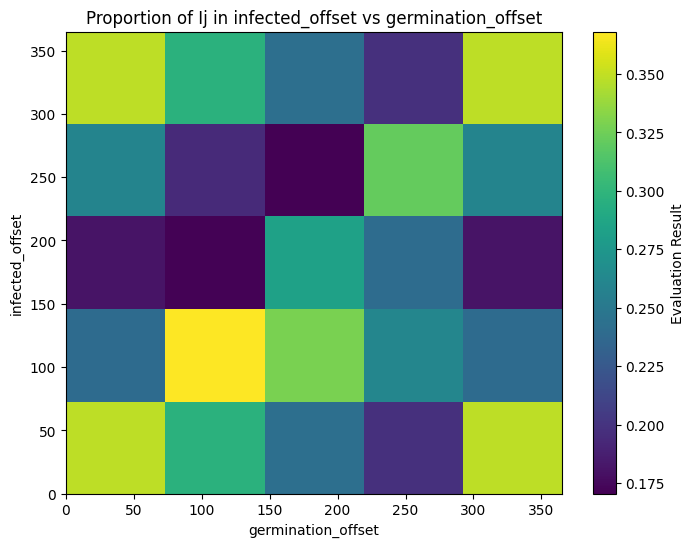

In [61]:
#EXAMPLE USAGE
param1_values = np.linspace(0, 365, 15)  # Create testing values for infected offset
param2_values = np.linspace(0, 365, 15)  # Create testing values for germination offset

# Initialize the model
model = Model()

#Initialize GraphModel with the model
# graph_model=GraphModel(model)
# graph_model.graph()

# Initialize RasterModel with the parameters to raster
raster_model = RasterModel(model, 'infected_offset', 'germination_offset', param1_values, param2_values)

# Run raster and plot heatmap
raster_model.raster()
raster_model.plot_heatmap()